In [ ]:
# importing libraries

In [ ]:
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import numpy as np
import os
from PIL import Image
from tensorflow.keras import Sequential, layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import layers, optimizers, callbacks
from PIL import Image
import requests
from io import BytesIO

# 1. Loading the data

In [ ]:
# Mount GDrive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Put Colab in the context of this challenge
import os

# os.chdir allows you to change directories, like cd in the Terminal
os.chdir('/content/drive/MyDrive/Colab_Notebooks/lewg_final_project/signsense')

In [ ]:
!pwd


/content/drive/MyDrive/Colab_Notebooks/lewg_final_project/signsense


In [ ]:
!ls

notebooks  raw_data  README.md	sign_asl


In [ ]:
!ls sign_asl

asl_alphabet_test  asl_alphabet_train


In [ ]:

def load_asl_data():

    data_path = '/content/drive/MyDrive/Colab_Notebooks/lewg_final_project/signsense/sign_asl/asl_alphabet_train/asl_alphabet_train'
    classes = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'K':9, 'L':10, 'M':11, 'N':12, "O":13, "P":14, 'Q':15, 'R':16, 'S':17, 'T':18, 'U':19,
               "V":20, 'W':21, 'X':22, "Y":23, 'del':24, 'nothing':25, 'space':26}
    imgs = []
    labels = []
    for (cl, i) in classes.items():
        images_path = [elt for elt in os.listdir(os.path.join(data_path, cl)) if elt.find('.jpg')>0]
        for img in tqdm(images_path[:3001]):
            path = os.path.join(data_path, cl, img)
            if os.path.exists(path):
                image = Image.open(path)
                image = image.resize((50, 50))
                imgs.append(np.array(image))
                labels.append(i)

    X = np.array(imgs)
    num_classes = len(set(labels))
    y = to_categorical(labels, num_classes)

    # Finally we shuffle:
    p = np.random.permutation(len(X))
    X, y = X[p], y[p]

    first_split = int(len(imgs) /6.)
    second_split = first_split + int(len(imgs) * 0.2)
    X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
    y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]

    return X_train, y_train, X_val, y_val, X_test, y_test, num_classes

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test, num_classes = load_asl_data()


100%|██████████| 3000/3000 [01:36<00:00, 31.23it/s] 


In [ ]:
print(X_train.shape, X_val.shape, X_test.shape)

(51300, 50, 50, 3) (16200, 50, 50, 3) (13500, 50, 50, 3)


In [ ]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# 2 .Visualization

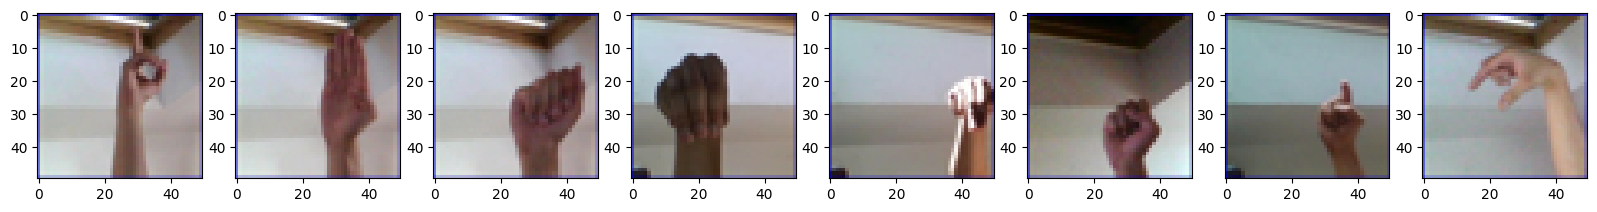

In [ ]:
plt.figure(figsize=(20,15))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(X_train[i])

In [ ]:
def dummy_model():
  input_shape= (50,50,3)
  model = Sequential()

  model.add(layers.Rescaling(1./255, input_shape = input_shape))
  model.add(layers.Conv2D(filters = 32, kernel_size = (5,5), activation="relu", padding = "same"))
  model.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )


  model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding = "same"))
  model.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )


  model.add(layers.Conv2D(filters = 128, kernel_size = (3,3), activation="relu", padding = "same"))
  model.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )

  model.add(layers.Flatten())

  # Here we flatten our data

  model.add(layers.Dense(128, activation="relu"))
  model.add(layers.Dropout(0.2))

  model.add(layers.Dense(64, activation="relu"))
  model.add(layers.Dropout(0.2))


# prediction layer
  model.add(layers.Dense(27, activation="sigmoid"))

# compiling model
  adam = optimizers.Adam(learning_rate = 0.001)
  model.compile(loss='categorical_crossentropy',
                optimizer= adam,
                metrics=['accuracy'])


  return model

In [ ]:
dummy_model= dummy_model()
dummy_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 50, 50, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 32)        2432      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 25, 25, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 13, 13, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 128)      

In [ ]:
MODEL = "dummy_model"

modelCheckpooint = callbacks.ModelCheckpoint("{}.h5".format(MODEL), monitor="val_loss", verbose=0, save_best_only=True)

LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)


In [ ]:
%%time
history = dummy_model.fit(X_train, y_train,
        epochs=15,
        validation_data= (X_val, y_val),
        callbacks = [modelCheckpooint, LRreducer, EarlyStopper])


Epoch 1/30
1604/1604 [==============================] - 377s 234ms/step - loss: 1.6203 - accuracy: 0.4850 - val_loss: 0.5041 - val_accuracy: 0.8240 - lr: 0.0010
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1604/1604 [==============================] - 355s 221ms/step - loss: 0.5382 - accuracy: 0.8126 - val_loss: 0.2045 - val_accuracy: 0.9314 - lr: 0.0010
Epoch 3/30
1604/1604 [==============================] - 368s 230ms/step - loss: 0.3093 - accuracy: 0.8919 - val_loss: 0.1278 - val_accuracy: 0.9590 - lr: 0.0010
Epoch 4/30
1604/1604 [==============================] - 368s 229ms/step - loss: 0.2118 - accuracy: 0.9281 - val_loss: 0.0567 - val_accuracy: 0.9828 - lr: 0.0010
Epoch 5/30
1604/1604 [==============================] - 366s 228ms/step - loss: 0.1636 - accuracy: 0.9457 - val_loss: 0.0629 - val_accuracy: 0.9786 - lr: 0.0010
Epoch 6/30
1604/1604 [==============================] - 367s 229ms/step - loss: 0.1231 - accuracy: 0.9592 - val_loss: 0.0225 - val_accuracy: 0.9933 - lr: 0.0010
Epoch 7/30
1604/1604 [==============================] - 365s 228ms/step - loss: 0.1099 - accuracy: 0.9639 - val_loss: 0.0196 - val_accuracy: 0.9936 - lr: 0.0010
Epoch 8/30
1604/1604 [=======================

# 3. CNN Models

## 3.1 Dummy model

In [ ]:
# Evaluation:
res = dummy_model.evaluate(X_test, y_test)
res

422/422 [==============================] - 27s 64ms/step - loss: 0.0016 - accuracy: 0.9998


[0.0016106108669191599, 0.9997777938842773]

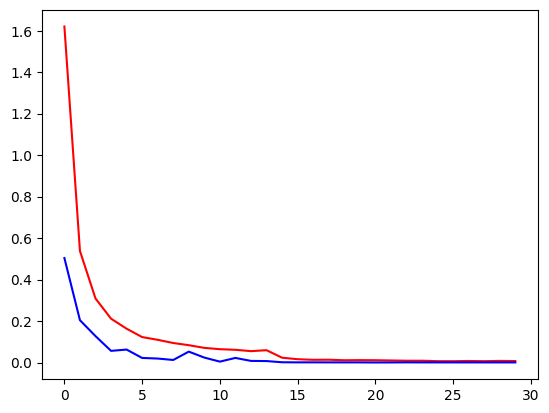

In [ ]:
plt.plot(history.history["loss"], 'r')
plt.plot(history.history["val_loss"], 'b')


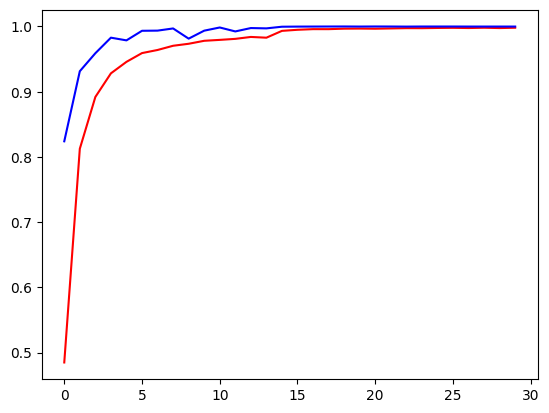

In [ ]:
plt.plot(history.history["accuracy"], 'r')
plt.plot(history.history["val_accuracy"], 'b')

### 3.1.1 prediction

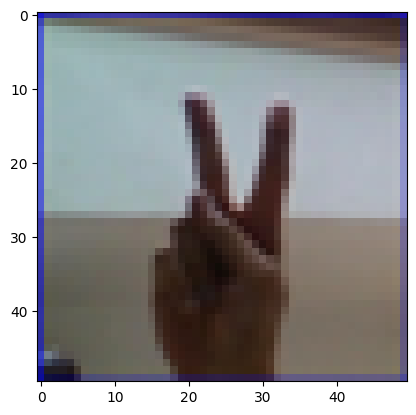

In [ ]:

test_data_path = '/content/drive/MyDrive/Colab_Notebooks/lewg_final_project/signsense/sign_asl/asl_alphabet_test/asl_alphabet_test'
files = os.listdir(test_data_path)
path = os.path.join(test_data_path, files[1])
image = Image.open(path)
image = image.resize((50, 50))
plt.imshow(image)

In [ ]:
path = os.path.join(test_data_path, files[2])
path

'/content/drive/MyDrive/Colab_Notebooks/lewg_final_project/signsense/sign_asl/asl_alphabet_test/asl_alphabet_test/I_test.jpg'

In [ ]:
img = np.array(image)
img = img.reshape((-1, 50, 50, 3))
res = dummy_model.predict(img)
res

1/1 [==============================] - 0s 156ms/step


array([[4.4899032e-11, 1.4793253e-04, 1.4195036e-23, 7.7140884e-16,
        1.3848868e-12, 1.2338583e-07, 8.1319094e-01, 1.6831036e-06,
        2.2424220e-03, 1.0000000e+00, 1.4648568e-08, 1.3052443e-03,
        9.2292805e-16, 1.2602831e-08, 1.8535399e-20, 3.1183204e-38,
        9.9054337e-01, 1.1878541e-25, 5.7889899e-24, 4.0196727e-16,
        2.6499861e-01, 9.8401558e-01, 6.4519631e-21, 1.5911385e-17,
        7.5419873e-21, 2.1721438e-23, 6.2924946e-06]], dtype=float32)

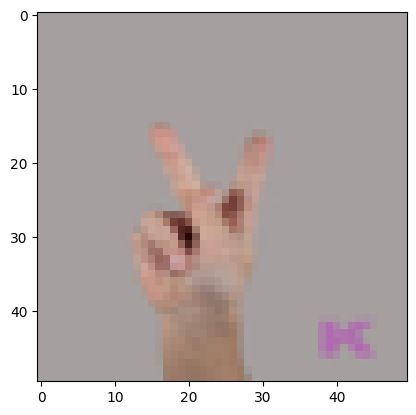

In [ ]:
url= 'https://thumbs.dreamstime.com/b/letter-k-made-fingers-grey-background-dactylology-nonverbal-alphabet-82541468.jpg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img = img.resize((50, 50))
plt.imshow(img)


In [ ]:
img2 = np.array(img)
img2 = img2.reshape((-1, 50, 50, 3))
res = dummy_model.predict(img2)
res

1/1 [==============================] - 0s 24ms/step


array([[4.5359542e-04, 7.7799477e-08, 0.0000000e+00, 0.0000000e+00,
        9.8402413e-22, 2.7343897e-24, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.4122884e-10,
        6.5433858e-14, 0.0000000e+00, 5.9123712e-21, 4.0612779e-21,
        2.1042568e-03, 2.2630784e-09, 0.0000000e+00, 5.7241541e-28,
        0.0000000e+00, 1.3006608e-08, 0.0000000e+00, 2.9718331e-32,
        0.0000000e+00, 1.0000000e+00, 0.0000000e+00]], dtype=float32)

In [ ]:
predicted_indc= np.argmax(res)
classes = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'J':9, 'K':10, 'L':11, 'M':12, 'N':13, "O":14, "P":15, 'Q':16, 'R':17, 'S':18, 'T':19, 'U':20,
               "V":21, 'W':22, 'X':23, "Y":24, "Z":25, 'del':26, 'nothing':27, 'space':28}
predicted_letter = [letter for letter, indic in classes.items() if indic == predicted_indc]
print(predicted_letter)


## 3.2 Good model

In [ ]:
def good_model():
  input_shape= (50,50,3)
  model = Sequential()

  model.add(layers.Rescaling(1./255, input_shape = input_shape))
  model.add(layers.Conv2D(filters = 32, kernel_size = (7,7), activation="relu", padding = "same"))
  model.add(BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )


  model.add(layers.Conv2D(filters = 64, kernel_size = (5,5), activation="relu", padding = "same"))
  model.add(BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )


  model.add(layers.Conv2D(filters = 128, kernel_size = (5,5), activation="relu", padding = "same"))
  model.add(BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )

  model.add(layers.Conv2D(filters = 512, kernel_size = (3,3), activation="relu", padding = "same"))
  model.add(BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same"))

  model.add(layers.Conv2D(filters = 1024, kernel_size = (3,3), activation="relu", padding = "same"))
  model.add(BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same"))

  model.add(layers.Flatten())

  # Here we flatten our data

  model.add(layers.Dense(512, activation="relu"))
  model.add(layers.Dropout(0.2))
  model.add(BatchNormalization())

  model.add(layers.Dense(128, activation="relu"))
  model.add(layers.Dropout(0.2))
  model.add(BatchNormalization())

  model.add(layers.Dense(64, activation="relu"))
  model.add(layers.Dropout(0.2))
  model.add(BatchNormalization())

# prediction layer
  model.add(layers.Dense(27, activation="sigmoid"))

# compiling model
  adam = optimizers.Adam(learning_rate = 0.001)
  model.compile(loss='categorical_crossentropy',
                optimizer= adam,
                metrics=['accuracy'])


  return model

In [ ]:
model_good = good_model()
model_good.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 50, 50, 3)         0         
                                                                 
 conv2d_21 (Conv2D)          (None, 50, 50, 32)        4736      
                                                                 
 batch_normalization_24 (Ba  (None, 50, 50, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 25, 25, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 25, 25, 64)        51264     
                                                                 
 batch_normalization_25 (Ba  (None, 25, 25, 64)       

In [ ]:


MODEL = "good_model"

modelCheckpooint = callbacks.ModelCheckpoint("{}.h5".format(MODEL), monitor="val_loss", verbose=0, save_best_only=True)

LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)


In [ ]:
%%time
history = model_good.fit(X_train, y_train,
        epochs=30,
        validation_data= (X_val, y_val),
        callbacks = [modelCheckpooint, LRreducer, EarlyStopper])


Epoch 1/30
1604/1604 [==============================] - ETA: 0s - loss: 1.2490 - accuracy: 0.6128

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1604/1604 [==============================] - 2366s 1s/step - loss: 1.2490 - accuracy: 0.6128 - val_loss: 10.1078 - val_accuracy: 0.0956 - lr: 0.0010
Epoch 2/30
1604/1604 [==============================] - 2337s 1s/step - loss: 0.2256 - accuracy: 0.9327 - val_loss: 0.0899 - val_accuracy: 0.9728 - lr: 0.0010
Epoch 3/30
1604/1604 [==============================] - 2393s 1s/step - loss: 0.1249 - accuracy: 0.9641 - val_loss: 0.0580 - val_accuracy: 0.9816 - lr: 0.0010
Epoch 4/30
1321/1604 [=======================>......] - ETA: 6:47 - loss: 0.0727 - accuracy: 0.9799

### 3.2.1 prediction

## 3.3 Model with data augmentation

### 3.3.1 prediction

## 3.4 Model with transfer learning

### 3.4.1 prediction

## 3.5 Model with mix of data augmnetation and transfer learning

### 3.5.1 prediction

# 4. Predicion function (chaging the probabilities to a letter)